In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Ag

In [2]:
fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수
df = fmax-fmin         # 주파수 대역폭

resolution = 50        # 시뮬레이션 해상도
nfreq = 1             # 추출할 주파수 개수
design_region_resolution = 50

In [48]:
tag_bot         = 0.5
tag_side        = 4
tsio2           = 4
tdesignregion   = 1
monitor_position =  1 / fcen *2
monitor_blank   = 1 / fcen * 0.1

tpml = 0.4

width_ag = 0.2
width_sio2 = 2

width_bot_ag = width_ag+width_sio2+width_ag

design_region_width = round(width_bot_ag, 3)
design_region_height = 1

Sx = tpml+width_bot_ag+tpml
Sy = tag_bot+tag_side+tdesignregion+monitor_position+monitor_blank+tpml

SiO2 = mp.Medium(index = 1.45)
TiO2 = mp.Medium(index = 2.6)

Nx = int(design_region_resolution * design_region_width) + 1
Ny = int(design_region_resolution * design_region_height) + 1

y_bottom = -Sy/2
center_y_ag = y_bottom + tag_bot / 2
center_y_sio2 = y_bottom + tag_bot + tsio2 / 2
center_y_design = y_bottom + tag_bot + tsio2 + design_region_height
center_y_monitor_position = y_bottom + tag_bot + tsio2 + design_region_height + monitor_position
center_y_source_position = y_bottom + tag_bot + 1/fcen 
center_Ag_x_position = design_region_width/2-width_ag/2 #+ tpml/2

boundary_layers = [mp.Absorber(tpml,direction=mp.X),
                   mp.PML(tpml,direction=mp.Y,side=mp.High)]

In [49]:
# 셀 크기 설정
cell_size = mp.Vector3(Sx, Sy)

# 기본 지오메트리 정의
geometry = [
    # Bottom Ag layer
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_bot_ag, tag_bot, 0),
        center=mp.Vector3(0, center_y_ag, 0)
    ),
    # SiO2 layer
    mp.Block(
        material=SiO2,
        size=mp.Vector3(width_sio2, tsio2, 0),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),
    # Side metal
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(-center_Ag_x_position, center_y_sio2, 0)
    ),
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(center_Ag_x_position, center_y_sio2, 0)
    ),
]


In [92]:
layer_num = 2

ML = (layer_num > 1)

region_height_each = design_region_height / layer_num
full_center_y = y_bottom + tag_bot + tsio2 + design_region_height/2

if ML:
    design_variables = []
    design_region = []
    for dv in range(layer_num):
        mg = mp.MaterialGrid(
            mp.Vector3(Nx, Ny),
            TiO2,       
            SiO2,       
            grid_type="U_MEAN",
            do_averaging=False
        )
        design_variables.append(mg)
        offset = ((layer_num - 1) / 2 - dv) * region_height_each
        center_y = full_center_y + offset

        dr = mpa.DesignRegion(
            mg,
            volume=mp.Volume(
                center=mp.Vector3(0, center_y, 0),
                size=mp.Vector3(design_region_width, region_height_each, 0),
            ),
        )
        design_region.append(dr)

        geometry.append(
            mp.Block(
                material=design_variables[dv],
                size=design_region[dv].size,
                center=design_region[dv].center
            )
        )
else:
    design_variables = mp.MaterialGrid(
        mp.Vector3(Nx, Ny),
        TiO2,
        SiO2,
        grid_type="U_MEAN",
        do_averaging=False
    )
    design_region = mpa.DesignRegion(
        design_variables,
        volume=mp.Volume(
            center=mp.Vector3(0, full_center_y, 0),
            size=mp.Vector3(design_region_width, region_height_each, 0),
        )
    )
    geometry.append(
        mp.Block(
            material=design_variables,
            size=design_region.size,
            center=design_region.center
        )
    )


In [93]:
src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)

sources = mp.Source(
            src,
            component=mp.Ez,
            center=mp.Vector3(
                0,
                center_y_source_position,  # Alq3 층의 중간 높이
                0
            )
        )

sim = mp.Simulation(
    resolution=resolution,
    sources=[sources],
    cell_size=cell_size,
    boundary_layers=boundary_layers,
    geometry=geometry,
    default_material=mp.Medium(index = 1),
    extra_materials=[Ag]
)

In [94]:
minimum_length = 0.09  # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)

# def mapping(x, eta, beta):
def mapping(x, eta_i, beta):

    # filter
    filtered_field = mpa.conic_filter(
        x,
        filter_radius,
        design_region_width,
        design_region_height,
        design_region_resolution,
    )

    # projection
    projected_field = mpa.tanh_projection(filtered_field, beta, eta_i)

    # interpolate to actual materials
    return projected_field.flatten()

In [95]:
def multiregion_mapping(
        x,                      # design variables (flattened stacked)
        layer_num,              # number of layers
        eta,                    # threshold point of the linear filter
        beta,                   # binarization parameter
        ind,                    # the index of the design variable to return (0: list, 1: flattened)
        Nx,                     # number of grid points in x-direction per layer
        Ny,                     # number of grid points in y-direction per layer
        filter_radius,          # filter radius for conic filter
        design_region_width_x,  # physical width of design region in x
        design_region_width_y,  # physical width of design region in y
        design_region_resolution,
        pad_value,              # padding for filter (unused here)
        o_grid                  # grid spacing (unused here)
    ):
    # reshape and separate layers
    X = x.reshape((Nx*Ny, layer_num)).T  # shape: (layer_num, Nx*Ny)

    processed = []  # store processed layer fields

    for layer_idx in range(layer_num):
        xi = X[layer_idx].reshape((Nx, Ny))
        # apply conic filter directly (no symmetry or padding)
        filtered = mpa.conic_filter(
            xi,
            filter_radius,
            design_region_width_x,
            design_region_width_y,
            design_region_resolution
        )
        # flatten back
        processed.append(filtered.flatten())

    # stack back into array for projection
    stacked = np.concatenate(processed, axis=0)
    # apply tanh projection
    projected = mpa.tanh_projection(stacked, beta, eta)

    # split back to layers
    split_layers = projected.reshape((layer_num, Nx*Ny))

    if ind == 0:
        # return list of per-layer arrays
        return [split_layers[i].copy() for i in range(layer_num)]
    elif ind == 1:
        # return flattened stacked array
        return split_layers.T.flatten()
    else:
        raise ValueError("ind must be 0 or 1; got {}".format(ind) )

In [114]:
design_region[1].center

Vector3<0.0, 1.2654545454545456, 0.0>

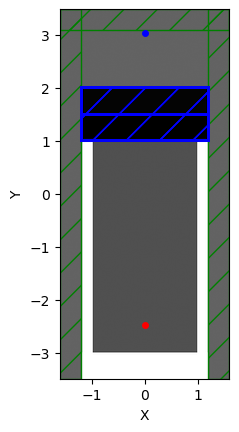

In [96]:
monitor_position_J, monitor_size = mp.Vector3(0, center_y_monitor_position), mp.Vector3(0,0)
FourierFields = mpa.FourierFields(sim,mp.Volume(center=monitor_position_J,size=monitor_size),mp.Ez,yee_grid=True)
ob_list = [FourierFields]

def J(fields):
    return npa.mean(npa.abs(fields) ** 2) # The index 1 corresponds to the point at the center of our monitor.

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=ob_list,
    design_regions=design_region,
    frequencies=[fcen],
    maximum_run_time=100,
)

opt.plot2D(True)

In [ ]:
class AdamOptimizer:
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, warmup_iters=10):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mt = None
        self.vt = None
        self.iter = 0
        self.warmup_iters = warmup_iters
    
    def update(self, v, gradient):
        if self.mt is None:
            self.mt = np.zeros_like(v)
        if self.vt is None:
            self.vt = np.zeros_like(v)
            
        #Adam에서는 기울기 값과 기울기의 제곱값의 지수이동평균을 활용하여 step 변회량을 조절
        self.iter += 1
        self.mt = self.beta1 * self.mt + (1 - self.beta1) * gradient           #m_(t)=beta_(1)*m_(t-1)+(1-beta_(1))*gradient
        self.vt = self.beta2 * self.vt + (1 - self.beta2) * (gradient ** 2)       #v_(t)=beta_(2)*v_(t-1)+(1-beta_(2))*(gradeint^2)
        
        # 초기 몇번의 update에서 0으로 편향되어 있어서 출발 지점에서 멀리 떨어진 곳으로 이동하는, 초기 경로의 편향 문제를 해결 하기 위해 unbiased하게 만들어줌
        m_hat = self.mt / (1 - self.beta1 ** self.iter)   #m_hat=m/(1-beta1**t)
        v_hat = self.vt / (1 - self.beta2 ** self.iter)
        
        # Warm-up 단계
        if self.iter <= self.warmup_iters:
            warmup_factor = self.iter / self.warmup_iters
            lr = self.lr * warmup_factor
        else:
            lr = self.lr   #lr_t <- alpha*sqrt
            
        #update = self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        update_factor= m_hat / (np.sqrt(v_hat) + self.epsilon) #theta_t <- theta_(t-1)-alpha_(t)*m_(t)/(sqrt(v_(t))+epsilon) alpha_(t)=learning rate
        update = lr * update_factor
        updated_v = v + update
        updated_v = np.clip(updated_v, 0.0, 1.0)
        
        adam_lr=np.mean(np.abs(update))
        adam_uf=np.mean(np.abs(update_factor))
        
        # adam_beta1=self.beta1
        # # adam_beta2=self.beta2
        adam_m=self.mt
        adam_v=self.vt
        adam_t=self.iter
        
        return updated_v, adam_lr, adam_uf, adam_m, adam_v, adam_t

# 이런 느낌으로 플롯

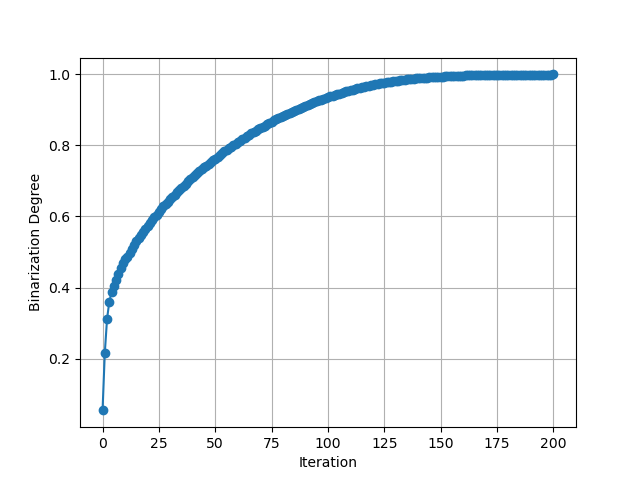



In [78]:
optimizer1 = AdamOptimizer(lr=0.02, beta1=0.9)
optimizer2 = AdamOptimizer(lr=0.02, beta1=0.9)

# 히스토리 배열 초기화
evaluation_history = []
beta_history = []
cur_iter = [0]

# 레이어별 업데이트 히스토리
g1_history, g2_history = [], []
x1_history, x2_history = [], []

lr_history1, uf_history1, t_history1 = [], [], []
lr_history2, uf_history2, t_history2 = [], [], []

# 목표 함수 실행 및 업데이트 함수 정의
def f(v, eta, cur_beta):
    size_each = Nx * Ny

    # 레이어별 변수 분리
    v1 = v[:size_each]
    v2 = v[size_each:2*size_each]

    # 매핑
    rho1 = mapping(v1, eta, cur_beta)
    rho2 = mapping(v2, eta, cur_beta)

    # 개별 평가 및 그레이디언트 계산
    f0_1, gradients1 = opt([rho1], need_value=True, need_gradient=True, beta=cur_beta)
    f0_2, gradients2 = opt([rho2], need_value=True, need_gradient=True, beta=cur_beta)
    # 합산된 FoM
    f0 = f0_1 + f0_2
    # 개별 그레이디언트 추출
    dJ1 = gradients1[0] if isinstance(gradients1, (list, tuple)) else gradients1
    dJ2 = gradients2[0] if isinstance(gradients2, (list, tuple)) else gradients2

    # 그레이디언트 평탄화 및 기록
    g1 = dJ1.flatten()
    g2 = dJ2.flatten()
    g1_history.append(g1.copy())
    g2_history.append(g2.copy())

    # 레이어별 Adam 업데이트
    v1_new, lr1, uf1, m1, v1_mom, t1 = optimizer1.update(v1, g1)
    v2_new, lr2, uf2, m2, v2_mom, t2 = optimizer2.update(v2, g2)

    # 업데이트된 변수 결합
    v_new = np.concatenate([v1_new, v2_new])
    x1_history.append(v1_new.copy())
    x2_history.append(v2_new.copy())

    # beta 업데이트
    beta_new = cur_beta + np.tanh((cur_beta - 0.5) * 0.01)

    # 히스토리 기록
    evaluation_history.append(f0)
    beta_history.append(beta_new)
    cur_iter[0] += 1

    lr_history1.append(lr1)
    uf_history1.append(uf1)
    t_history1.append(t1)

    lr_history2.append(lr2)
    uf_history2.append(uf2)
    t_history2.append(t2)

    print(f"Iter {cur_iter[0]}: FoM={float(np.real(f0)):.3e}, beta={beta_new:.4f}")

    return v_new, m1, m2, beta_new

In [ ]:
def f_multi(x, eta, cur_beta):
    size_each = Nx * Ny
    # 리스트로 초기화
    v_new = np.zeros_like(x)
    rhos = multiregion_mapping(x, layer_num, eta, cur_beta, ind=0,
                                 Nx=Nx, Ny=Ny,
                                 filter_radius=filter_radius,
                                 design_region_width_x=design_region_width,
                                 design_region_width_y=region_height_each,
                                 design_region_resolution=design_region_resolution,)
                                #  pad_value=pad_value, o_grid=o_grid)

    f0_total = 0
    grads = []
    # 각 레이어별 FoM, gradient 계산
    for i, rho in enumerate(rhos):
        f0_i, grad_i = opt([rho], need_value=True, need_gradient=True, beta=cur_beta)
        # gradient 추출
        dJi = grad_i[0] if isinstance(grad_i, (list, tuple)) else grad_i
        gi = dJi.flatten()
        grads.append(gi)
        f0_total += f0_i
        # gradient 히스토리 기록
        g_history[i].append(gi.copy())

    # 각 레이어별 Adam 업데이트
    for i in range(layer_num):
        start = i * size_each
        end = (i+1) * size_each
        vi = x[start:end]
        vi_new, lr_i, uf_i, m_i, v_i_mom, t_i = optimizer[i].update(vi, grads[i])
        v_new[start:end] = vi_new
        # 변수 히스토리 기록
        x_history[i].append(vi_new.copy())
        lr_history[i].append(lr_i)
        uf_history[i].append(uf_i)
        t_history[i].append(t_i)

    # beta 업데이트
    beta_new = cur_beta + np.tanh((cur_beta - 0.5) * 0.01)

    # 전역 히스토리 기록
    evaluation_history.append(f0_total)
    beta_history.append(beta_new)
    cur_iter[0] += 1

    print(f"Iter {cur_iter[0]}: FoM={float(np.real(f0_total)):.3e}, beta={beta_new:.4f}")

    return v_new, beta_new

In [79]:
total_iter = 50
cur_beta=1
n=Nx*Ny*2
x=np.ones(n)*0.5
x_history = []

mp.verbosity(0)
x = np.ones(2 * Nx * Ny) * 0.5
for it in range(total_iter):
    x, m1, m2, cur_beta = f(x, eta_i, cur_beta)
    x_history.append(x.copy())

IndexError: list index out of range

In [101]:
optimizers = [AdamOptimizer(lr=0.02, beta1=0.9) for _ in range(layer_num)]
evaluation_history = []
beta_history = []
g_history = [[] for _ in range(layer_num)]
x_history = [[] for _ in range(layer_num)]
lr_history = [[] for _ in range(layer_num)]
uf_history = [[] for _ in range(layer_num)]
t_history = [[] for _ in range(layer_num)]
cur_iter = [0]

# 최적화 업데이트 함수 정의
def f_multi(x, eta, cur_beta):
    size_each = Nx * Ny

    # --- 1) 레이어별 rho 벡터 생성 ---
    # ind=0: 리스트로 (각 레이어당 Nx*Ny 길이의 벡터) 반환
    rhos = multiregion_mapping(
        x,            # flattened design vector
        layer_num,    # 레이어 개수
        eta,          # threshold η
        cur_beta,     # binarization β
        0,            # ind=0 → 리스트 반환
        Nx,           # grid x count
        Ny,           # grid y count
        filter_radius,
        design_region_width,
        design_region_height,
        design_region_resolution,
        pad_value=0,
        o_grid=0
    )

    # --- 2) 한 번에 objective & gradient 계산 ---
    # opt(rho_list) → (FoM_total, [grad_layer0, grad_layer1, …])
    f0_total, grad_list = opt(rhos, need_value=True, need_gradient=True, beta=cur_beta)

    # --- 3) 각 gradient를 flatten →
    grads = [g.flatten() for g in grad_list]

    # 기록
    evaluation_history.append(f0_total)
    for i, g in enumerate(grads):
        g_history[i].append(g.copy())

    # --- 4) 레이어별 Adam 업데이트 ---
    v_new = np.zeros_like(x)
    for i in range(layer_num):
        start, end = i*size_each, (i+1)*size_each
        vi = x[start:end]
        vi_new, lr_i, uf_i, m_i, v_i_mom, t_i = optimizers[i].update(vi, grads[i])
        v_new[start:end] = vi_new

        # 히스토리 기록
        x_history[i].append(vi_new.copy())
        lr_history[i].append(lr_i)
        uf_history[i].append(uf_i)
        t_history[i].append(t_i)

    # --- 5) beta 업데이트 & 기록 ---
    beta_new = cur_beta + np.tanh((cur_beta - 0.5) * 0.01)
    beta_history.append(beta_new)
    cur_iter[0] += 1

    print(f"Iter {cur_iter[0]}: FoM={float(np.real(f0_total)):.3e}, beta={beta_new:.4f}")

    return v_new, beta_new


# 최적화 루프 실행
total_iter = 50
cur_beta = 1.0
x = np.ones(layer_num * Nx * Ny) * 0.5
for it in range(total_iter):
    x, cur_beta = f_multi(x, eta=0.5, cur_beta=cur_beta)

Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 1: FoM=1.774e-03, beta=1.0050
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 2: FoM=1.797e-03, beta=1.0100
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 3: FoM=1.834e-03, beta=1.0152
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 4: FoM=1.887e-03, beta=1.0203
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 5: FoM=1.961e-03, beta=1.0255
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 6: FoM=2.062e-03, beta=1.0308
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 7: FoM=2.197e-03, beta=1.0361
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 8: FoM=2.376e-03, beta=1.0414
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 9: FoM=2.608e-03, beta=1.0468
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 10: FoM=2.905e-03, beta=1.0523
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 11: FoM=3.276e-03, beta=1.0578
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 12: FoM=3.694e-03, beta=1.0634
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 13: FoM=4.155e-03, beta=1.0690
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 14: FoM=4.655e-03, beta=1.0747
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 15: FoM=5.190e-03, beta=1.0805
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 16: FoM=5.756e-03, beta=1.0863
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 17: FoM=6.351e-03, beta=1.0922
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 18: FoM=6.973e-03, beta=1.0981
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 19: FoM=7.619e-03, beta=1.1041
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 20: FoM=8.284e-03, beta=1.1101
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 21: FoM=8.963e-03, beta=1.1162
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 22: FoM=9.650e-03, beta=1.1224
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 23: FoM=1.034e-02, beta=1.1286
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 24: FoM=1.101e-02, beta=1.1349
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 25: FoM=1.167e-02, beta=1.1412
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 26: FoM=1.229e-02, beta=1.1476
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 27: FoM=1.288e-02, beta=1.1541
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 28: FoM=1.343e-02, beta=1.1606
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 29: FoM=1.386e-02, beta=1.1672
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 30: FoM=1.413e-02, beta=1.1739
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 31: FoM=1.434e-02, beta=1.1807
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 32: FoM=1.451e-02, beta=1.1875
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 33: FoM=1.465e-02, beta=1.1943
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 34: FoM=1.476e-02, beta=1.2013
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 35: FoM=1.485e-02, beta=1.2083
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 36: FoM=1.491e-02, beta=1.2154
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 37: FoM=1.497e-02, beta=1.2225
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 38: FoM=1.500e-02, beta=1.2298
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 39: FoM=1.502e-02, beta=1.2371
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 40: FoM=1.503e-02, beta=1.2444
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 41: FoM=1.503e-02, beta=1.2519
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 42: FoM=1.502e-02, beta=1.2594
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 43: FoM=1.501e-02, beta=1.2670
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 44: FoM=1.498e-02, beta=1.2747
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 45: FoM=1.496e-02, beta=1.2824
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 46: FoM=1.493e-02, beta=1.2902
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 47: FoM=1.490e-02, beta=1.2981
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 48: FoM=1.487e-02, beta=1.3061
Starting forward run...
Starting adjoint run...
Calculating gradient...


Iter 49: FoM=1.484e-02, beta=1.3142
Starting forward run...
Starting adjoint run...
Calculating gradient...
Iter 50: FoM=1.482e-02, beta=1.3223


In [11]:
foms = np.real(evaluation_history_adam)
best_idx = np.argmax(foms)

init_idx = 4  # 0-based index → 5번째
if len(foms) > init_idx:
    init_fom    = foms[init_idx]
    init_beta   = beta_history[init_idx]
    init_design = x_history[init_idx]
    print(f"[Iteration 5] FoM = {init_fom:.4e}, β = {init_beta:.4f}, 디자인 (첫 10개) = {init_design[:10]} …")
else:
    print(f"Iteration 수({len(foms)})가 5보다 작아 5번째 정보가 없습니다.")

# --- 2) FoM 최대일 때 정보 ---
best_fom    = foms[best_idx]
best_beta   = beta_history[best_idx]
best_design = x_history[best_idx]
print(f"[Best Iteration {best_idx+1}] FoM = {best_fom:.4e}, β = {best_beta:.4f}, 디자인 (첫 10개) = {best_design[:10]} …")

# --- 3) 마지막 iteration 정보 ---
last_idx    = len(foms) - 1
last_fom    = foms[last_idx]
last_beta   = beta_history[last_idx]
last_design = x_history[last_idx]
print(f"[Last Iteration {last_idx+1}] FoM = {last_fom:.4e}, β = {last_beta:.4f}, 디자인 (첫 10개) = {last_design[:10]} …")


[Iteration 5] FoM = 5.1072e-03, β = 1.0255, 디자인 (첫 10개) = [0.46992576 0.47007394 0.47006488 0.47004833 0.47001847 0.46992842
 0.52814094 0.47035152 0.47024828 0.47020804] …
[Best Iteration 50] FoM = 8.9083e-02, β = 1.3223, 디자인 (첫 10개) = [0.09538716 0.         0.         0.         0.         0.
 0.2835844  0.91676042 0.10358971 0.        ] …
[Last Iteration 50] FoM = 8.9083e-02, β = 1.3223, 디자인 (첫 10개) = [0.09538716 0.         0.         0.         0.         0.
 0.2835844  0.91676042 0.10358971 0.        ] …


# FOM이 떨어지는 지점에서 beta 값이 수정되는건지?
# Multi layer 

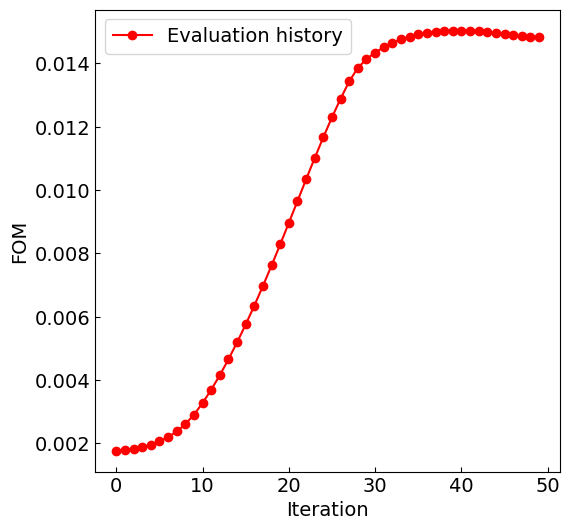

In [102]:
plt.figure(figsize = (6,6))

plt.plot(evaluation_history, 'or-',   label='Evaluation history',)

plt.xlabel('Iteration',fontsize = 14)
plt.ylabel('FOM',fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

# plt.title('Optimization', fontsize = 16)
plt.tick_params(direction = 'in')

plt.legend( fontsize = 14,)

plt.show()

In [ ]:
# np.savetxt("adam_weights_2lambda_pos_mean_objf.txt", design_variables.weights)

In [ ]:
# np.savetxt("adam_weights_2lambda_pos_new_objf.txt", design_variables.weights)

In [ ]:
# np.savetxt("adam_weights_1lambda_pos_new_objf.txt", design_variables.weights)

In [ ]:
# np.savetxt("adam_weights_2lambda_pos.txt", design_variables.weights)

In [ ]:
# import numpy as np

# data = np.loadtxt('adam_weights_1lambda_pos_new_objf.txt')

# print("Loaded array shape:", data.shape)

# opt.update_design([data])
# # data


Loaded array shape: (6171,)


In [ ]:
# data_init = np.loadtxt('init_design.txt')
# data_best = np.loadtxt('best_design.txt')
# data_last = np.loadtxt('last_design.txt')

# # opt.update_design([data_init])
# # opt.update_design([data_best])
# opt.update_design([data_last])

In [ ]:
# multi = design_variables.weights
# opt.update_design([multi])

(-1.2, 1.2, 1.0154545454545456, 2.0154545454545456)

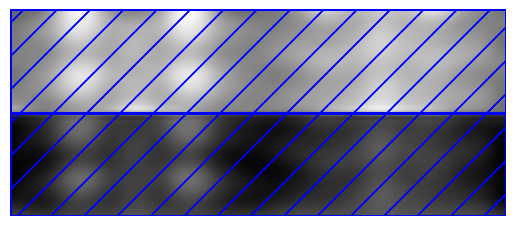

In [130]:
opt.plot2D(
    True,
    output_plane = mp.Volume(size = mp.Vector3(2.4, 1, 0), center = mp.Vector3(0, full_center_y,0)),
    
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
)
plt.axis(False)

<Axes: xlabel='X', ylabel='Y'>

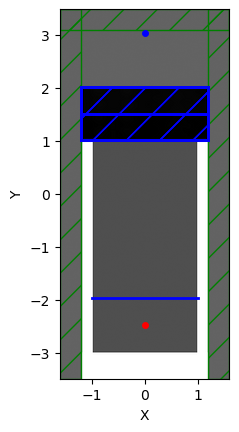

In [131]:
offset = 0.01
flux_size = 0.02
mn_size = 2

monitor_position_y, monitor_size = mp.Vector3(0, center_y_monitor_position+1/2), mp.Vector3(mn_size,0)

#### input source의 flux ####
input_flux = opt.sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(
            center=sources.center + mp.Vector3(0, 1/fcen, 0),
                    size=mp.Vector3(width_sio2,0 ),
                    ),
    )

#### output flux -> add flux로 계산한 poynting vector ####
out_flux = opt.sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(
                center=monitor_position_y,
                size=monitor_size,
                # direction=mp.Y
                # weight=-1
        )
    )

#### output flux -> 성분별 field를 뽑고, poynting vector를 계산할 예정 ####
dft_fields = opt.sim.add_dft_fields([mp.Ex, mp.Ey, mp.Ez, mp.Hx, mp.Hy, mp.Hz], fcen, 0, 1, 
                                    center = monitor_position_y,
                                    size = monitor_size, 
                                    yee_grid=True)

opt.sim.plot2D()


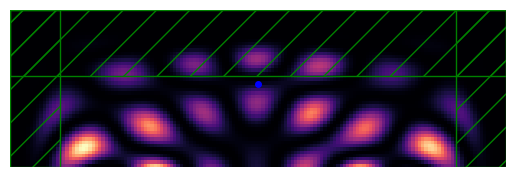

In [132]:
opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10/df, mp.Ez, sources.center, 1e-3))

opt.sim.plot2D(
    fields=mp.Ez,
    output_plane=mp.Volume(
    center = monitor_position_y,
    size = mp.Vector3(3, 2)),
    field_parameters={
        'post_process': lambda x: np.abs(np.real(x))**2,  # 복소수 필드 x → intensity |x|^2
        'cmap': 'magma',                         # 원하시는 colormap
        'alpha': 1,                            # 투명도
        'interpolation': 'none'
    },
    eps_parameters={'cmap':'magma','alpha':0.5}
)
plt.axis(False)
plt.show()

<Axes: xlabel='X', ylabel='Y'>

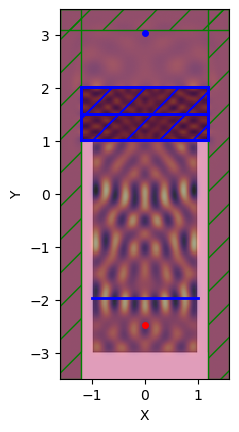

In [133]:
opt.sim.plot2D(fields = mp.Ez,
           field_parameters={
        'cmap': 'magma',    # magma 컬러맵 지정
        'alpha': 0.5,       # 필드 투명도 (0.0~1.0)
        'interpolation': 'none'
    }
)

In [134]:
external_field_array = (sim.get_dft_array(dft_fields, mp.Ez, 0))

N = len(external_field_array)
W = mn_size                           # μm 단위 모니터 폭
x = np.linspace(-W/2, W/2, N)                     # μm 단위 위치
z = abs(center_y_monitor_position - center_y_source_position)  # μm 단위 거리

# 3) Intensity 계산
I = np.abs(external_field_array)**2

# 4) θ 축으로 플롯
plt.figure(figsize=(6,6))
plt.plot(x, I, 'bo-')


plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
plt.ylabel('Intensity |E|²',       fontsize=14)
# plt.ylabel('phase',       fontsize=14)
plt.title(r'Monitor size: $2\mu m$', fontsize=16)
plt.tick_params(direction = 'in')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.tight_layout()
plt.show()

TypeError: len() of unsized object

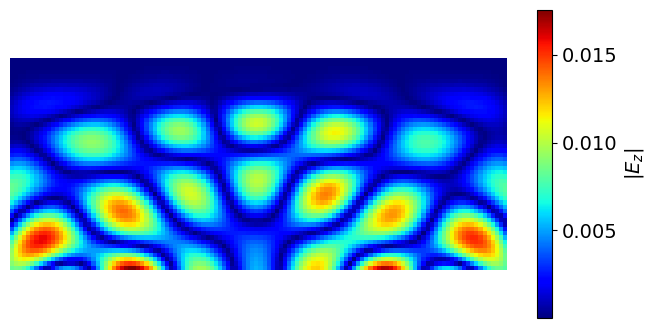

In [135]:
import numpy as np
import matplotlib.pyplot as plt
import meep as mp

nx = int(design_region_resolution * design_region_width) + 1
x_res = np.linspace(-design_region_width/2,
                     design_region_width/2,
                     nx)

y_start = center_y_design + design_region_height/2
y_end   = center_y_monitor_position + 1/fcen
ny = int(design_region_resolution * (y_end - y_start)) + 1
y_res = np.linspace(y_start, y_end, ny)

vol = mp.Volume(
    center=mp.Vector3(0, (y_start + y_end)/2, 0),
    size=  mp.Vector3(design_region_width,
                      y_end - y_start,
                      0)
)
Ez_slice = opt.sim.get_array(mp.Ez, vol).T   # shape == (ny, nx)

plt.figure(figsize=(8,4))
plt.imshow(
    np.abs(Ez_slice),      # (ny, nx)
    origin='lower',
    extent=[x_res.min(), x_res.max(), y_res.min(), y_res.max()],
    aspect='equal',
    cmap='jet'
)

cbar = plt.colorbar()
cbar.set_label(r'$|E_z|$', fontsize=14)
cbar.ax.tick_params(labelsize=14)

# plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
# plt.ylabel('Height $y$ (µm)',           fontsize=14)
# plt.title(r'Monitor size: $2\ \mu m$',   fontsize=16)

# 틱 폰트 크기 및 방향 맞추기
plt.tick_params(direction='in', labelsize=14)
# plt.tight_layout()
plt.axis('off')
plt.show()

In [202]:
eqe = mp.get_fluxes(out_flux)[0]/mp.get_fluxes(input_flux)[0]*100
    
print("Input flux :", mp.get_fluxes(input_flux)[0])
print("Output flux :", mp.get_fluxes(out_flux)[0])
print("EQE(%) :", eqe,"%")

Input flux : 0.447849911237925
Output flux : 0.3173413627147607
EQE(%) : 70.85886471152381 %
